In [1]:
import sys, os
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
# import math
# from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.colors as clr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
sys.path.append("../SpaGCN/SpaGCN_package/")
import SpaGCN as spg

# Load sample data

In [3]:
# Read in brain3 anndata file
adata_brain3 = ad.read_h5ad("../data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad")

In [4]:
# subset to neurons, one section, genes only (no blanks)
divisions_neuronal = ["2 Subpallium GABAergic",  # not many cells in brain3, but lots in RT/ZI in brain1
                      "3 PAL-sAMY-TH-HY-MB-HB neuronal",  # nearly all TH cells in brain3, vast majority in brain1
                      "4 CBX-MOB-other neuronal"]  # not many cells in this division in brain3, but lots in RT/ZI in brain1
sections = ['1199651054'] #1199651060, 1199651057, 1199651054, 1199651048, 1199651045, 1199651042, 1199651039, 1199651033
genes = [x for x in adata_brain3.var_names if 'Blank' not in x]

adata_neuronal = adata_brain3[adata_brain3.obs["division_id_label"].isin(divisions_neuronal)]
adata_spaGCN = adata_neuronal[adata_neuronal.obs['section'].isin(sections), genes]
adata_spaGCN = adata_spaGCN[np.random.permutation(adata_spaGCN.obs_names), :]

# adata_spaGCN

In [5]:
# make a copy, rather than a view, so we can write to it later on
adata_spaGCN = adata_spaGCN.copy()

In [6]:
sec_name = 'sec'+sections[0]
results_dir = '../results/'+sec_name+'/'

# /results/ gets wiped at the end of a capsule workstation run, so need to re-make
os.makedirs(results_dir, exist_ok=True)

## Extract appropriate spatial coordinates

SpaGCN tutorial for 10x Visium uses two sets of coordinates, (y_array, x_array) and (y_pixel, x_pixel), seem to be simply the same data in different units (maybe: position in Visium grid array vs actual pixel position from the images)

For now, assuming that I can just use the 'spatial_cirro' coordinates from obsm interchangeably for both sets of coordinates.

Will default to using (y_pixel, x_pixel) in place of (y_array, x_array)

In [7]:
# Tom used the spatial_cirro coordinates for NSF, so let's try that first
# need to convert to their own lists
# using spatial_cirro coords for both _pixel and _array coordinates
x_pixel = adata_spaGCN.obsm['spatial_cirro'][:,0].tolist()
y_pixel = adata_spaGCN.obsm['spatial_cirro'][:,1].tolist()

# also store in .obs so they're easier to use later for plotting, etc.
adata_spaGCN.obs['x_pixel'] = adata_spaGCN.obsm['spatial_cirro'][:,0].tolist()
adata_spaGCN.obs['y_pixel'] = adata_spaGCN.obsm['spatial_cirro'][:,1].tolist()

# Spatial Domain Detection w/ SpaGCN

## Spatial coordinates preprocessing

In [8]:
# Calculate adjacent matrix. If histlogy image is not available, set histology to FALSE
adj_matrix = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt(results_dir+'adj_matrix.csv', adj_matrix, delimiter=',')

Calculateing adj matrix using xy only...


## Expression data preprocessing

In [9]:
# if not already loaded in this notebook, run:
# adata_spaGCN=sc.read("./data/151673/sample_data.h5ad")
# adj=np.loadtxt('./data/151673/adj.csv', delimiter=',')

In [10]:
# otherwise, proceed:
adata_spaGCN.var_names_make_unique()
spg.prefilter_genes(adata_spaGCN,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata_spaGCN)

In [11]:
# SpaGCN is set up for normalized log counts, which is already what's found in 
# our ad.X structure, so I'm not going to do anything for now, but if something
# breaks, this might be something to try

# alternatively, if I want to match their method:
#
# sc.pp.normalize_per_cell(adata_spaGCN)
# sc.pp.log1p(adata_spaGCN)
#
# I would need to create a new anndata object where ad.X is layer='raw' and then
# use scanpy to normalize and take the log

## Set hyperparameters

- p: Percentage of total expression contributed by neighborhoods.
- l: Parameter to control p.



In [12]:
p=0.5 
# Find the l value given p
l_from_p0pt5 = spg.search_l(p, adj_matrix, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 3185.786003076021]
Run 2: l [0.01, 500.005], p [0.0, 1097.985595703125]
Run 3: l [0.01, 250.0075], p [0.0, 330.1701354980469]
Run 4: l [0.01, 125.00874999999999], p [0.0, 95.52583312988281]
Run 5: l [0.01, 62.509375], p [0.0, 26.789348602294922]
Run 6: l [0.01, 31.2596875], p [0.0, 7.046181678771973]
Run 7: l [0.01, 15.63484375], p [0.0, 1.6654024124145508]
Run 8: l [7.822421875, 15.63484375], p [0.2776923179626465, 1.6654024124145508]
Run 9: l [7.822421875, 11.728632812499999], p [0.2776923179626465, 0.8517917394638062]
Run 10: l [7.822421875, 9.77552734375], p [0.2776923179626465, 0.5323394536972046]
Run 11: l [8.798974609375, 9.77552734375], p [0.39637064933776855, 0.5323394536972046]
Run 12: l [9.2872509765625, 9.77552734375], p [0.46227777004241943, 0.5323394536972046]
recommended l =  9.53138916015625


In [13]:
# # If the number of clusters known, we can use the spg.search_res() function to search for suitable resolution(optional)
# # For this toy data, we set the number of clusters=7 since this tissue has 7 layers
# n_clusters = 15
# # Set seed
# r_seed = t_seed = n_seed = 100

# # Search for suitable resolution
# resolution = spg.search_res(adata_spaGCN, adj_matrix, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

## Run SpaGCN

Since we don't know the number of clusters we're looking for and I don't want 
to guess and bias it, we can't calculate the optimal resolution.

According to their paper, there should be a way to vary the resolution paramter 
from 0.1 to 1.0 to select the res that gives the Louvain method output the 
highest Silhouette score ... but I don't see how/where to do that? 

So, I'm just going to do it manually by sampling three resolutions to start and
seeing what they output: 
- 1.0 (what they used for the mouse Visium dataset in the tutorial)
- 0.4 (default)
- 0.7 (in between)

In [14]:
def run_SpaGCN_domain_detection(ad, adj_matrix, p=0.5, l=None, resolution=0.4,
                                initialization_method='louvain', seed=100, 
                                tolerance=5e-3, lr=0.05, max_epochs=200, 
                                save_adata=True):
    
    # Determine if we need to calculate the l parameter
    if (l==None) & (p!=None):
        # Find the l value given p
        l = spg.search_l(p, adj_matrix, start=0.01, end=1000, tol=0.01, 
                         max_run=100)
    # to save the time it would take to calculate l, you can directly input it
    elif (l!=None) & (p!=None):
        print('Skipping p calculation; using l input parameter.')
        # l remains set to whatever was input
    elif (l==None) & (p==None):
        raise Exception('Please input a number for either p or l. Both cannot be None.')
    
    # Make and set classifer
    clf = spg.SpaGCN()
    clf.set_l(l)
    
    # set adata column names
    # resolution MUST use the ones & tenths places with a decimal pt between (e.g. 1.0 or 0.7 NOT 1 or 0.75)
    res_str = str(resolution)
    predicted_col = 'res'+res_str[0]+'pt'+res_str[-1]
    predicted_refined_col = 'res'+res_str[0]+'pt'+res_str[-1]+'_refined'

    # Set seeds
    r_seed = t_seed = n_seed = seed  # default seed is preset from tutorial
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    
    # Run
    # default params are presets from tutorial
    clf.train(ad, adj_matrix, init_spa=True, init=initialization_method,
              tol=tolerance, lr=lr, max_epochs=max_epochs, res=resolution)
    y_pred, prob = clf.predict()
    
    # Add predictions into obsm of the existing adata object
    obsm_key = 'spaGCN_predicted_domains'
    # if the spaGCN obsm df doesn't exist yet, need to make it
    if obsm_key not in adata_spaGCN.obsm:
        new_obsm_df = pd.DataFrame({predicted_col: y_pred},
                                   index=adata_spaGCN.obs_names)
        new_obsm_df[predicted_col] = new_obsm_df[predicted_col].astype('category')
        adata_spaGCN.obsm[obsm_key] = new_obsm_df
    else:
        adata_spaGCN.obsm[obsm_key][predicted_col] = y_pred
        adata_spaGCN.obsm[obsm_key][predicted_col] = adata_spaGCN.obsm[obsm_key][predicted_col].astype('category')

    # Do cluster refinement (optional)
    # shape="square" for ST data (="hexagon" for Visium data)
    adj_2d = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
    refined_pred = spg.refine(sample_id=ad.obs.index.tolist(), 
                              pred=ad.obsm[obsm_key][predicted_col].tolist(), dis=adj_2d, 
                              shape="square")
    # Add refined predictions into the existing adata object
    ad.obsm[obsm_key][predicted_refined_col] = refined_pred
    ad.obsm[obsm_key][predicted_refined_col] = ad.obsm[obsm_key][predicted_refined_col].astype('category')
    
    # save to results folder
    if save_adata:
        ad.write_h5ad(results_dir+'SpaGCN_domain_prediction_results.h5ad')
    
    return ad

### resolution 1.1

In [15]:
# adata_spaGCN = run_SpaGCN_domain_detection(adata_spaGCN, adj_matrix, l=l_from_p0pt5, 
#                                            resolution=1.1, save_adata=False)
# adata_spaGCN.obsm['spaGCN_predicted_domains']

### resolution=1.0

In [16]:
adata_spaGCN = run_SpaGCN_domain_detection(adata_spaGCN, adj_matrix, l=l_from_p0pt5, 
                                           resolution=1.0, save_adata=True)
adata_spaGCN

Skipping p calculation; using l input parameter.
Initializing cluster centers with louvain, resolution =  1.0
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.004383780013948391 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 37
Calculateing adj matrix using xy only...


AnnData object with n_obs × n_vars = 10037 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI', 'x_pi

### resolution=0.7

In [17]:
adata_spaGCN = run_SpaGCN_domain_detection(adata_spaGCN, adj_matrix, l=l_from_p0pt5, 
                                           resolution=0.7, save_adata=True)
adata_spaGCN

Skipping p calculation; using l input parameter.
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.003387466374414666 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 31
Calculateing adj matrix using xy only...


AnnData object with n_obs × n_vars = 10037 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI', 'x_pi

### resolution=0.4

In [18]:
adata_spaGCN = run_SpaGCN_domain_detection(adata_spaGCN, adj_matrix, l=l_from_p0pt5, 
                                           resolution=0.4, save_adata=True)
adata_spaGCN

Skipping p calculation; using l input parameter.
Initializing cluster centers with louvain, resolution =  0.4
Epoch  0
Epoch  10
Epoch  20
delta_label  0.003985254558134901 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 25
Calculateing adj matrix using xy only...


AnnData object with n_obs × n_vars = 10037 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI', 'x_pi

## Plot spatial domains

In [19]:
# source: https://sashamaps.net/docs/resources/20-colors/
sasha_trubetskoy_colors_21 = ['#e6194B', '#3cb44b', '#ffe119',  # red, green, yellow,
                              '#4363d8', '#f58231', '#911eb4',  # blue, orange, purple,
                              '#42d4f4', '#f032e6', '#bfef45',  # cyan, magenta, lime,
                              '#fabed4', '#469990', '#dcbeff',  # pink, teal, lavender,
                              '#9A6324', '#aaffc3', '#a9a9a9',  # brown, mint, grey,
                              '#000000',                        # black,
                              '#808000', '#800000', '#000075',  # olive, maroon, navy (dark and harder to tell apart f/ each other)
                              '#ffd8b1', '#fffac8']  # apricot, beige (light, hardest to see in scatter plots w/ white background)

In [20]:
# Compare initial domain predictions w/ refined domain predictions

# fig, axes = plt.subplots(2, 1, figsize=(20,20))

# # Plot predicted spatial domains
# ax = axes[0]
# domains_pred ='pred_res1pt0'
# num_celltype=len(adata_spaGCN.obs[domains_pred].unique())
# # adata_spaGCN.uns[domains_pred+"_colors"]=list(plot_palette_dict[:num_celltype])
# s0 = sc.pl.scatter(adata_spaGCN, x="x_pixel", y="y_pixel", ax=ax, alpha=1,
#                    color=domains_pred, title=domains_pred, color_map=plot_palette_dict, 
#                    show=False, size=200000/adata_spaGCN.shape[0])
# ax.set_aspect('equal', 'box')

# # Plot refined spatial domains
# ax = axes[1]
# domains_ref ='pred_refined_res1pt0'
# num_celltype=len(adata_spaGCN.obs[domains_ref].unique())
# # adata_spaGCN.uns[domains_ref+"_colors"]=list(plot_color[:num_celltype])
# s1 = sc.pl.scatter(adata_spaGCN, x="x_pixel", y="y_pixel", ax=ax, alpha=1,
#                    color=domains_ref, title=domains_ref, color_map=plot_palette_dict, 
#                    show=False, size=200000/adata_spaGCN.shape[0])
# ax.set_aspect('equal', 'box')

# # Save
# fig.savefig(results_dir+'brain3_'+sec_name+'_SpaGCN_spatial_domains_'+domains_pred+'.png', bbox_inches='tight')

### plot_spaGCN_domains()

In [42]:
def plot_spaGCN_domains(ad, pred_col, plot_title=None):
    # set default plot title
    if plot_title==None:
        plot_title = 'SpaGCN MERFISH domains\n'+pred_col

    fig = plt.figure(figsize=(16,8))
    ax = plt.gca()
    marker_size = 15000/ad.shape[0]
    
    # hard-coding colors that I find to be easily distinguishable
    # source: https://sashamaps.net/docs/resources/20-colors/
    domain_colors = ['#e6194B', '#3cb44b', '#ffe119',  # red, green, yellow,
                     '#4363d8', '#f58231', '#911eb4',  # blue, orange, purple,
                     '#42d4f4', '#f032e6', '#bfef45',  # cyan, magenta, lime,
                     '#fabed4', '#469990', '#dcbeff',  # pink, teal, lavender,
                     '#9A6324', '#aaffc3', '#a9a9a9',  # brown, mint, grey,
                     '#000000',                        # black,
                     '#808000', '#800000', '#000075',  # olive, maroon, navy (dark and harder to tell apart f/ each other)
                     '#ffd8b1', '#fffac8',             # apricot, beige (light, hardest to see in scatter plots w/ white background)
                     '#915282', '#ff7266',             # extra colors from colorcet.glaseby (dusty purple, salmon, 
                     '#8287ff', '#9ae4ff', '#eb0077',  # periwinkle, light blue, dark pink,
                     '#ff4600']                        # red-orange,
    
    # set domain:color mapping dict & save to ad.uns so future plots look the same
    obsm_key = 'spaGCN_predicted_domains'
    spg_domain_ids = sorted(ad.obsm[obsm_key][pred_col].unique().tolist())
    palette_dict = dict(zip(spg_domain_ids, domain_colors))
    ad.uns[pred_col+"_colors"] = palette_dict

    # scatter plot iteratively (best way to use color palette dictionary)
    for domain in spg_domain_ids:
        curr_domain_ad = ad[ad.obsm[obsm_key][pred_col]==domain]
        s = ax.scatter(curr_domain_ad.obs['x_pixel'], 
                       curr_domain_ad.obs['y_pixel'],
                       c=palette_dict[domain], 
                       label=domain,
                       s=marker_size)
    # legend properties
#     lgd = ax.legend(loc="center left", bbox_to_anchor=(1.,0.5), frameon=False,
#                     markerscale=7, fontsize=14)#, scatterpoints=1)
    lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5,0.), ncol=4, 
                    frameon=False, markerscale=7, fontsize=14)#, scatterpoints=1)
    lgd.set_title('SpaGCN domains',prop={'size':14})  # set legend title fontsize
    # hide all x-y axes/ticks/labels
    ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # other plot properties
    ax.set_aspect('equal', 'box')
    plt.title(title, fontsize=14)

    # Save
    fig.savefig(results_dir+'brain3_'+sec_name+'_SpaGCN_spatial_domains_'+pred_col+'.png', bbox_inches='tight')
    
    return ad, fig

### plot_spaGCN_domains_separately()

In [22]:
def plot_spaGCN_domains_separately(ad, pred_col, n_subplot_col=4):
    
    fig = plt.figure(figsize=(30, 30))

    # set grid geometry based on the number of domains
    obsm_key = 'spaGCN_predicted_domains'
    spg_domain_ids = sorted(ad.obsm[obsm_key][pred_col].unique().tolist())
    n_cols = n_subplot_col
    n_rows = int(np.ceil(len(spg_domain_ids)/n_cols))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n_rows, n_cols),  # creates 2x2 grid of axes
                     axes_pad=(0.1,0.6),  # pad between axes in inch.
                     share_all=True
                     )

    # set marker size
    marker_size = 5 #20000/ad.shape[0] 
    color_palette = ad.uns[pred_col+"_colors"]

    # plot each domain separately
    for i, domain in enumerate(spg_domain_ids):
        ax = grid[i]

        # split off current domain from all others
        curr_domain_ad = ad[ad.obsm[obsm_key][pred_col]==domain]
        other_domains_ad = ad[ad.obsm[obsm_key][pred_col]!=domain]

        # plot all other domains in grey
        s0 = ax.scatter(other_domains_ad.obs['x_pixel'],
                        other_domains_ad.obs['y_pixel'],
                        c='silver', s=marker_size/2, alpha=0.1)

        # plot current domain in it's assigned color
        curr_domain_color = color_palette[domain]
        s0 = ax.scatter(curr_domain_ad.obs['x_pixel'],
                        curr_domain_ad.obs['y_pixel'],
                        c=curr_domain_color, s=marker_size,
                        label='SpaGCN domain '+str(domain))
        lgd = ax.legend(loc="lower center", bbox_to_anchor=(0.5,0.95), 
                        frameon=False, markerscale=7, fontsize=16)
        ax.set_aspect('equal', 'box')
        # hide all x-y axes, ticks, labels, etc.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
        
        n_plots = i  # counter so we can hide extra grids at the end

    # turn off axes for the empty subplots, which is just a hacky fix because
    # ngrids=len(svg) doesn't work in this version of matplotlib
    for j in np.arange(n_plots+1,((n_cols*n_rows))):
        ax = grid[j]
        ax.set_visible(False)
        
    # Save
    fig.savefig(results_dir+'brain3_'+sec_name+'_SpaGCN_spatial_domains_'+pred_col+'_indiv.png', bbox_inches='tight')
        
    return fig

### resolution 1.1

In [23]:
# # Plot refined spatial domains all together
# resolution = 1.1
# res_str = str(resolution)
# predicted_col = 'res'+res_str[0]+'pt'+res_str[-1]
# predicted_refined_col = 'res'+res_str[0]+'pt'+res_str[-1]+'_refined'

# title = 'SpaGCN MERFISH domains\n(Louvain initialization resolution parameter = '+res_str+')'

# adata_spaGCN, fig_res1pt1_all = plot_spaGCN_domains(adata_spaGCN, predicted_refined_col, plot_title=title)

In [24]:
# # Plot refined spatial domains on separate subplots
# fig_res1pt1_each = plot_spaGCN_domains_separately(adata_spaGCN, predicted_refined_col)

### resolution=1.0

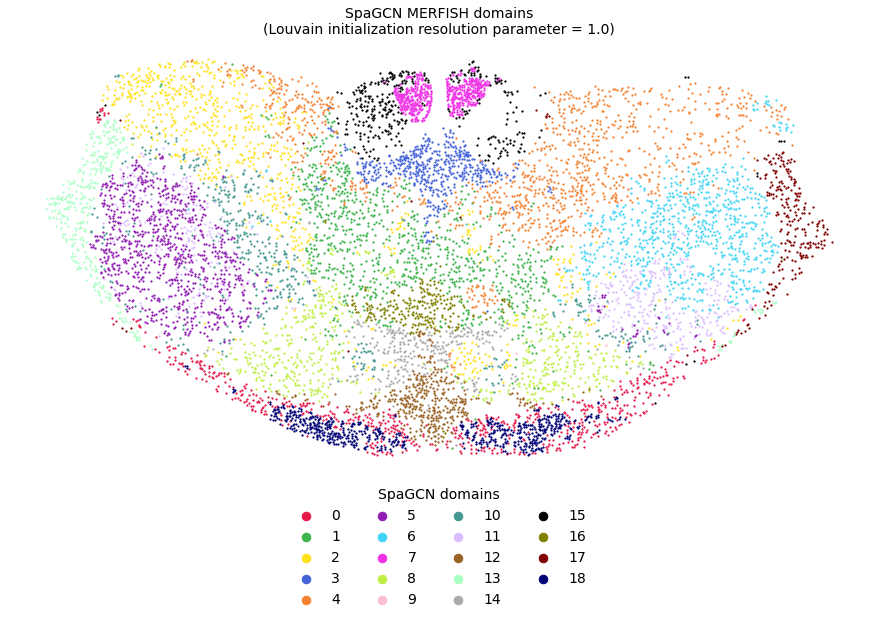

In [43]:
# Plot refined spatial domains all together
resolution = 1.0
res_str = str(resolution)
predicted_col = 'res'+res_str[0]+'pt'+res_str[-1]
predicted_refined_col = 'res'+res_str[0]+'pt'+res_str[-1]+'_refined'

title = 'SpaGCN MERFISH domains\n(Louvain initialization resolution parameter = '+res_str+')'

adata_spaGCN, fig_res1pt0_all = plot_spaGCN_domains(adata_spaGCN, predicted_refined_col, plot_title=title)

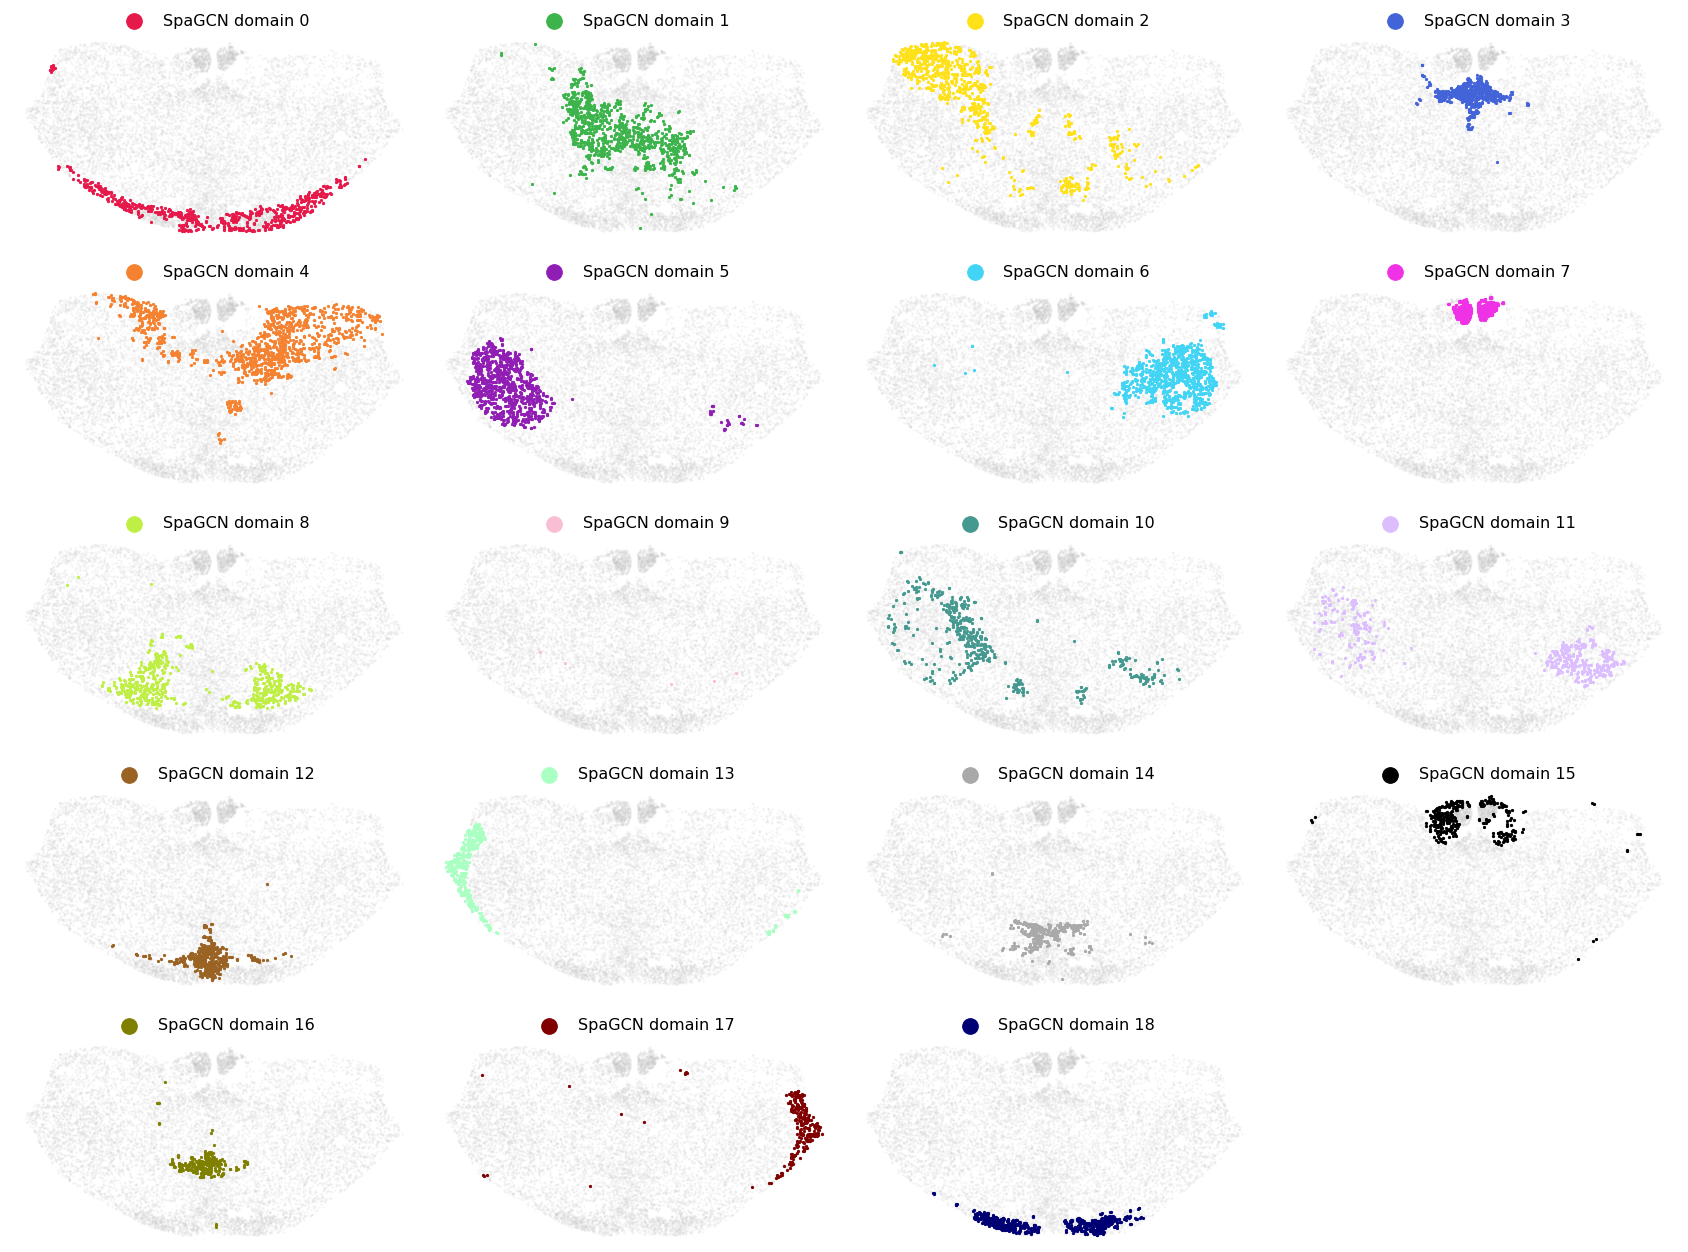

In [26]:
# Plot refined spatial domains on separate subplots
fig_res1pt0_each = plot_spaGCN_domains_separately(adata_spaGCN, predicted_refined_col)

### resolution=0.7

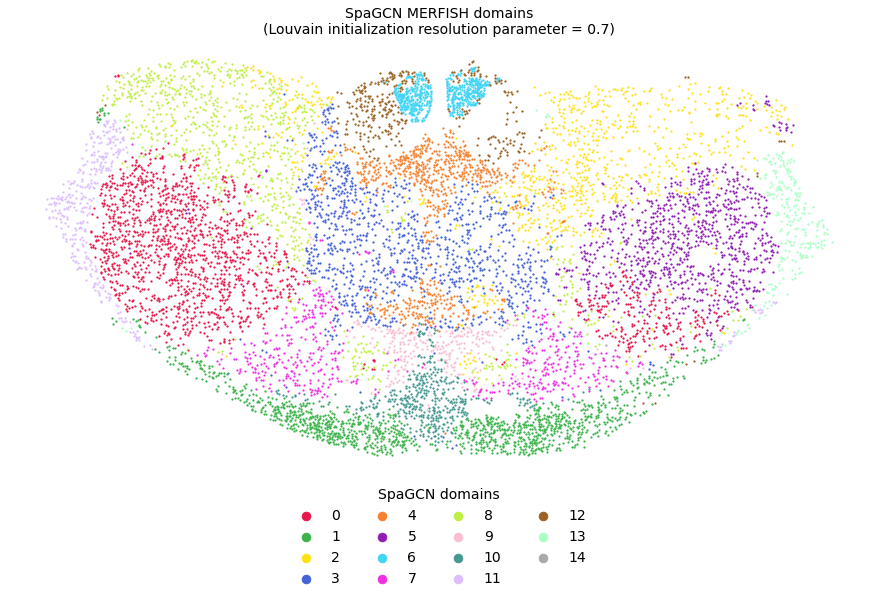

In [44]:
# Plot refined spatial domains all together
resolution = 0.7
res_str = str(resolution)
predicted_col = 'res'+res_str[0]+'pt'+res_str[-1]
predicted_refined_col = 'res'+res_str[0]+'pt'+res_str[-1]+'_refined'

title = 'SpaGCN MERFISH domains\n(Louvain initialization resolution parameter = '+res_str+')'

adata_spaGCN, fig_res0pt7_all = plot_spaGCN_domains(adata_spaGCN, predicted_refined_col, plot_title=title)

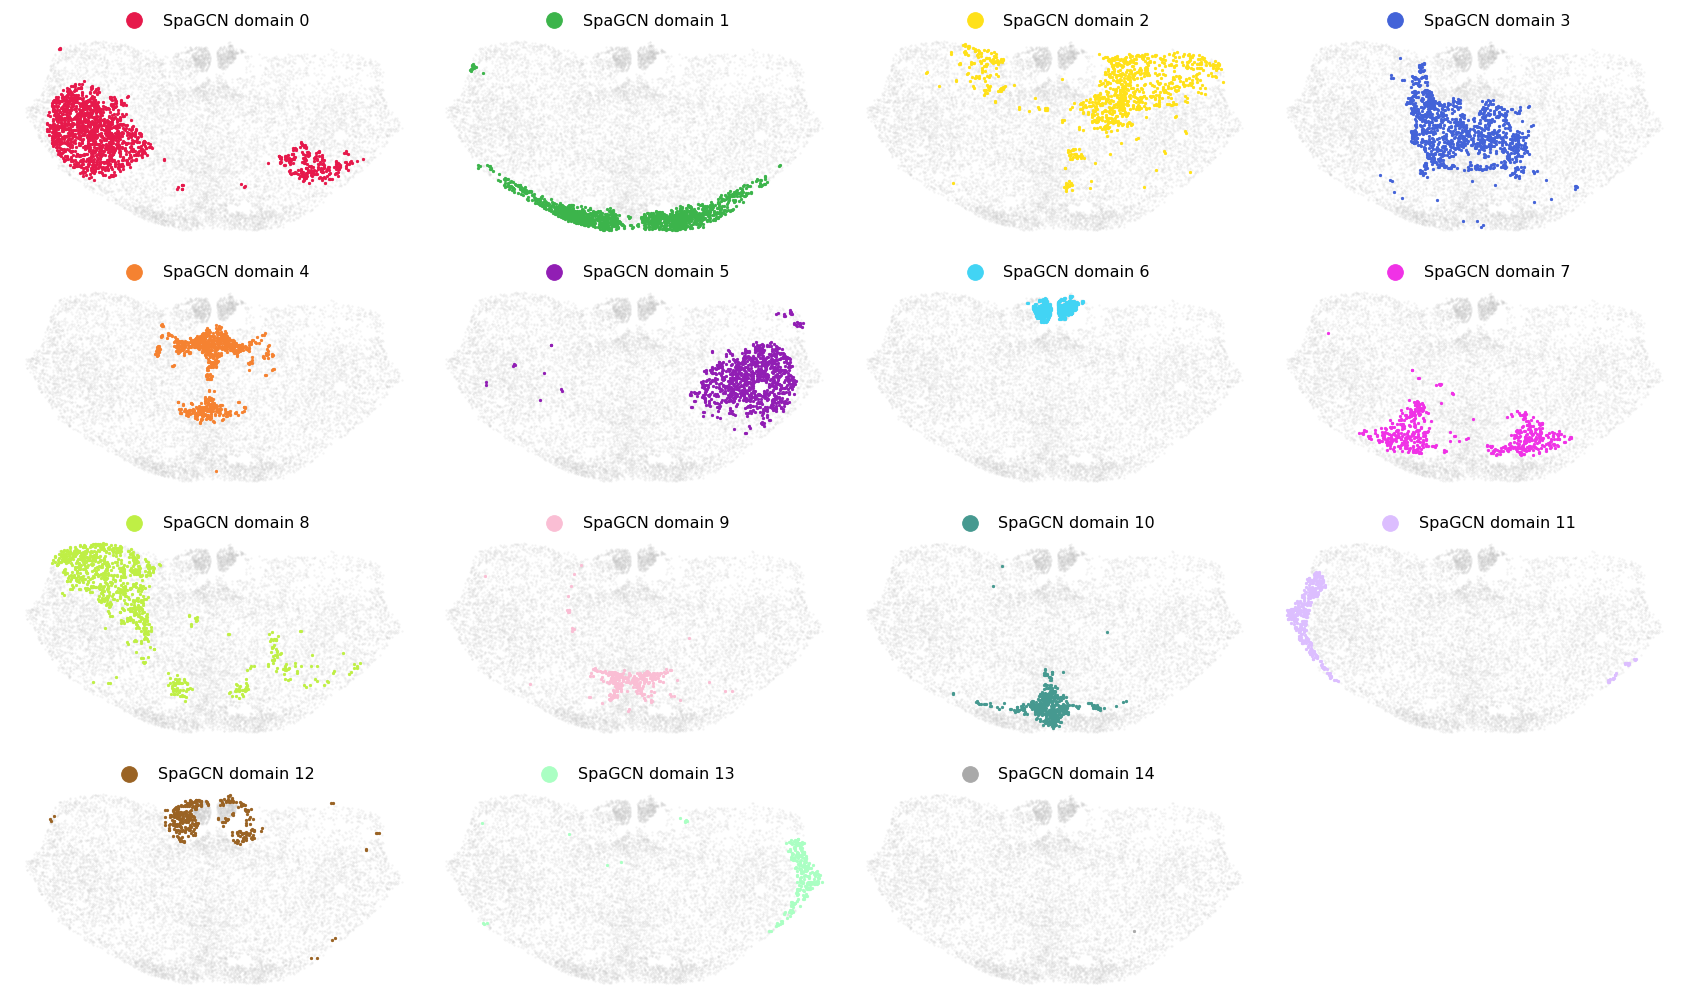

In [28]:
# Plot refined spatial domains on separate subplots
fig_res0pt7_each = plot_spaGCN_domains_separately(adata_spaGCN, predicted_refined_col, n_subplot_col=4)

### resolution=0.4

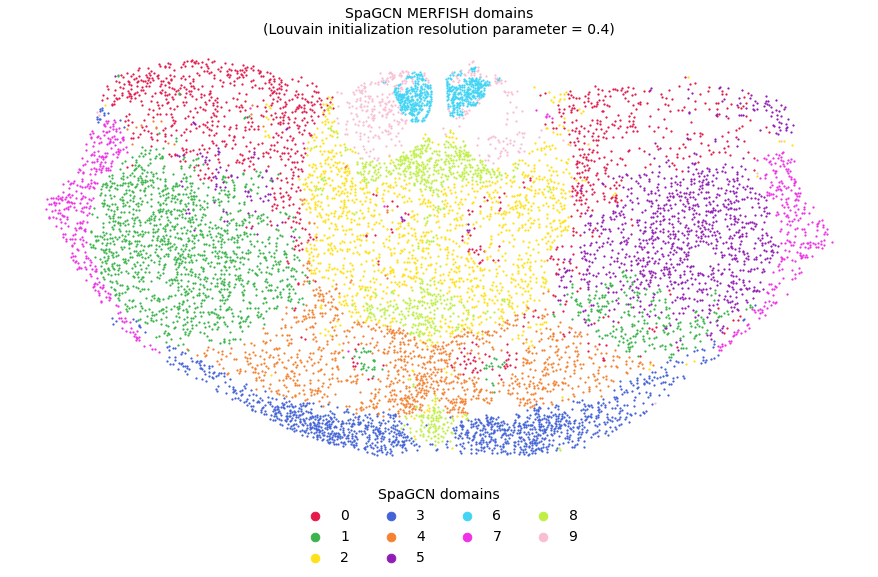

In [45]:
# Plot refined spatial domains all together
resolution = 0.4
res_str = str(resolution)
predicted_col = 'res'+res_str[0]+'pt'+res_str[-1]
predicted_refined_col = 'res'+res_str[0]+'pt'+res_str[-1]+'_refined'

title = 'SpaGCN MERFISH domains\n(Louvain initialization resolution parameter = '+res_str+')'

adata_spaGCN, fig_res1pt0_all = plot_spaGCN_domains(adata_spaGCN, predicted_refined_col, plot_title=title)

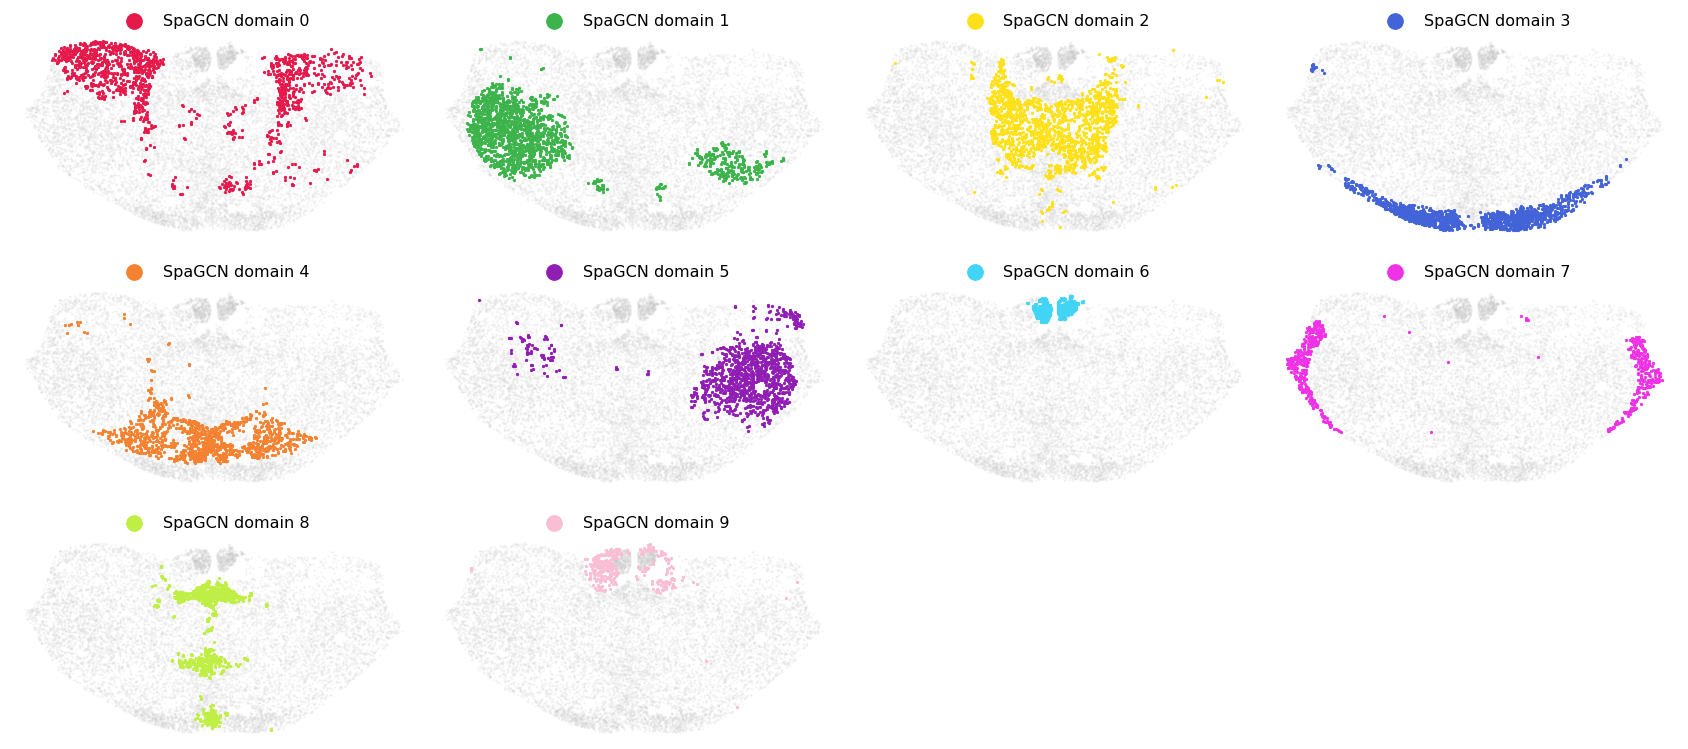

In [30]:
# Plot refined spatial domains on separate subplots
fig_res1pt0_each = plot_spaGCN_domains_separately(adata_spaGCN, predicted_refined_col)

# Find SVGs

## find_svgs()

In [31]:
def find_svgs(ad, domain, pred_col_name):
    'Wrapper to run all the steps to find SVGs in a given SpaGCN domain'
    
    # Set filtering criteria
    min_in_group_fraction=0.8
    min_in_out_group_ratio=1
    min_fold_change=1.5

    # Set search radius such that each spot in the target domain has approximately 
    # 10 neighbors on average
    obsm_key = 'spaGCN_predicted_domains'
    adj_2d = spg.calculate_adj_matrix(x=ad.obs["x_pixel"], y=ad.obs["y_pixel"], 
                                      histology=False)
    start = np.quantile(adj_2d[adj_2d!=0],q=0.001)
    end = np.quantile(adj_2d[adj_2d!=0],q=0.1)
    r = spg.search_radius(target_cluster=domain, cell_id=ad.obs.index.tolist(),
                          x=ad.obs["x_pixel"], y=ad.obs["y_pixel"],
                          pred=ad.obsm[obsm_key][pred_col_name].tolist(), 
                          start=start, end=end, num_min=10, num_max=14, 
                          max_run=100)

    # Detect neighboring domains
    nbr_domians = spg.find_neighbor_clusters(target_cluster=domain,
                                             cell_id=ad.obs.index.tolist(), 
                                             x=ad.obs["x_pixel"].tolist(), 
                                             y=ad.obs["y_pixel"].tolist(), 
                                             pred=ad.obsm[obsm_key][pred_col_name].tolist(),
                                             radius=r,
                                             ratio=1/2)

    nbr_domians = nbr_domians[0:3]
    # rank_genes_groups() expects to find things in .obs not .obsm
    ad.obs[pred_col_name] = ad.obsm[obsm_key][pred_col_name].tolist()
    de_genes_info = spg.rank_genes_groups(input_adata=ad,
                                          target_cluster=domain,
                                          nbr_list=nbr_domians, 
                                          label_col=pred_col_name, 
                                          adj_nbr=True, 
                                          log=True)

    # Filter genes
    de_genes_info = de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    filtered_info = de_genes_info
    filtered_info = filtered_info[(filtered_info["pvals_adj"]<0.05) &
                                  (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                  (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                                  (filtered_info["fold_change"]>min_fold_change)]
    filtered_info = filtered_info.sort_values(by="in_group_fraction", 
                                              ascending=False)
    filtered_info["target_domain"] = domain
    filtered_info["neighbors"] = str(nbr_domians)
    print("SVGs for domain ", str(domain),":", filtered_info["genes"].tolist())
    
    return filtered_info

## plot_svgs_expression()

In [32]:
def plot_svgs_expression(ad, svgs_df, domain, color_map='Blues'):
    
    svgs = svgs_df['genes'].tolist()

    # set vmax and vmin for the colorbar
    svg_expr = ad.X.A[:,ad.var.index.isin(svgs)]
    vmin = np.min(svg_expr.flatten())
    vmax = np.max(svg_expr.flatten())
    
    # set marker size
    marker_size = 30000/ad.shape[0]
    
    # set the grid geometry based on the # of svgs
    n_cols = 4  # four fit nicely horizontally
    n_rows = int(np.ceil(len(svgs) / n_cols))

    fig = plt.figure(figsize=(20,40))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(n_rows,n_cols), # ngrids=int(len(svgs[0:5])),
                     axes_pad=0.5,
                     cbar_location="right", cbar_mode="edge",
                     cbar_size="5%", cbar_pad=0.05
                     )
    
    # one subplot for each SVG
    for i, gene in enumerate(svgs):
        ax = grid[i]
        ad.obs["expr"] = ad.X.A[:,ad.var.index==gene]
        s = ax.scatter(ad.obs["x_pixel"], ad.obs["y_pixel"], alpha=1, 
                       c=ad.obs["expr"], cmap=color_map, vmin=vmin, vmax=vmax,
                       s=marker_size)
        ax.set_title(gene, fontsize=20)
        ax.set_aspect('equal', 'box')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
        ax.set_facecolor('lightgrey')
        cbar = plt.colorbar(s, cax=grid.cbar_axes[i])
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('log2(CPV+1)', fontsize=12)
        n_plots = i

    # turn off axes for the empty subplots, which is just a hacky fix because
    # ngrids=len(svg) doesn't work in this version of matplotlib
    for j in np.arange(n_plots+1,((n_cols*n_rows))):
        ax = grid[j]
        ax.set_visible(False)
   
    fig.savefig(results_dir+'brain3_'+sec_name+'_SpaGCN_domain'+str(domain)+'_SVGs'+".png", 
                bbox_inches='tight')
    
    svgs_list = svgs
    return svgs_list, fig

## RT

In [33]:
# # Use the domain that corresponds to RT, which is 5 in this run
# target_domain = 0
# pred_col = 'res1pt0_refined'

# # use SpaGCN to find SVGs for RT
# svgs_df_RT = find_svgs(adata_spaGCN, target_domain, pred_col)

# # sort list of SVGs by fold_change between target domain & the other domains
# svgs_df_RT.sort_values(by='fold_change', ascending=False, inplace=True)

In [34]:
# # plot all SVGs as expression heatmaps
# svg_list_RT, fig_RT = plot_svgs_expression(adata_spaGCN, svgs_df_RT, 
#                                            target_domain, color_map='Blues')

# Identify "MetaGene"

In [35]:
# # Plot single gene that we'll use as the starting gene to build a MetaGene
# target_domain = 6  # RT
# pred_col = 'res0pt7_refined'
# palette = adata_spaGCN.uns[pred_col+"_colors"]
# starting_gene = 'Trh'  # SVG with the 2nd highest fold_change value for domain=6 (RT)

# fig, axes = plt.subplots(1, 2, figsize=(20,6))
# marker_size = 30000/adata_spaGCN.shape[0]

# # Plot to highlight just the target_domain
# ax = axes[0]
# # all other domains in grey
# non_target_domain_cells = adata_spaGCN[adata_spaGCN.obs[pred_col]!=target_domain]
# s0 = ax.scatter(non_target_domain_cells.obs['x_pixel'],
#                 non_target_domain_cells.obs['y_pixel'],
#                 c='lightgrey', s=marker_size, alpha=0.5)
# # target domain in it's assigned color
# target_domain_cells = adata_spaGCN[adata_spaGCN.obs[pred_col]==target_domain]
# target_domain_color = palette[target_domain]
# s0 = ax.scatter(target_domain_cells.obs['x_pixel'],
#                 target_domain_cells.obs['y_pixel'],
#                 c=target_domain_color, label='SpaGCN domain '+str(target_domain),
#                 s=marker_size)
# ax.set_aspect('equal', 'box')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# lgd = ax.legend(loc="lower center", bbox_to_anchor=(0.5,1.), frameon=False,
#                 markerscale=5, fontsize=12)#, scatterpoints=1)
# plt.title(title, fontsize=14)


# # Plot gene expression for the starting gene
# ax = axes[1]
# adata_spaGCN.obs["expr"] = adata_spaGCN.X.A[:,adata_spaGCN.var.index==starting_gene]
# s = ax.scatter(adata_spaGCN.obs["x_pixel"], adata_spaGCN.obs["y_pixel"], alpha=1, 
#                 c=adata_spaGCN.obs["expr"], cmap='Blues', s=marker_size)
# ax.set_title(starting_gene)
# ax.set_aspect('equal', 'box')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# # ax.set_facecolor('lightgrey')
# plt.subplots_adjust(wspace=0.05)
# plt.colorbar(s, ax=axes.ravel().tolist(), shrink=0.65)

    
# fig.savefig(results_dir+'SpaGCN_domain'+str(target_domain)+'_'+starting_gene+".png", bbox_inches='tight')

In [36]:
# meta_name, meta_exp = spg.find_meta_gene(input_adata=adata_spaGCN,
#                                          pred=adata_spaGCN.obs[pred_col].tolist(),
#                                          target_domain=target_domain,
#                                          start_gene=starting_gene,
#                                          mean_diff=0,
#                                          early_stop=True,
#                                          max_iter=3,
#                                          use_raw=False)

# adata_spaGCN.obs["meta"] = meta_exp

# # plot metagene
# fig = plt.figure(figsize=(12,6))
# ax = plt.gca()

# # Plot gene expression for the starting gene
# adata_spaGCN.obs["expr"] = adata_spaGCN.X.A[:,adata_spaGCN.var.index==starting_gene]
# s = ax.scatter(adata_spaGCN.obs["x_pixel"], adata_spaGCN.obs["y_pixel"], alpha=1, 
#                 c=adata_spaGCN.obs["meta"], cmap='Blues', s=marker_size)
# ax.set_title(meta_name)
# ax.set_aspect('equal', 'box')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel(None)
# ax.set_ylabel(None)
# ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# # ax.set_facecolor('lightgrey')
# plt.subplots_adjust(wspace=0.05)
# plt.colorbar(s, ax=ax, shrink=0.85)
# plt.savefig(results_dir+'SpaGCN_domain'+str(target_domain)+'_metagene_'+meta_name+'.png', bbox_inches='tight')
# # plt.close()